In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px

In [2]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 環境設定

In [3]:
DATA_PATH = "./data"
RESULT_PATH = "./results"

# 関数定義

In [4]:
def count_feature_xs(df, feature_x: str):
    return len([col for col in df.columns if feature_x in col])

In [5]:
def cosine_similarity(y_true, y_pred):
    if isinstance(y_true, pd.Series):
        y_true = y_true.values.reshape(-1)
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values.reshape(-1)
    score = np.dot(y_true, y_pred) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))
    return "cosine_similarity", score, True

# 分析

## データ読み込み

In [6]:
train_data = pd.read_parquet(Path(DATA_PATH, "train.parquet"))
test_data = pd.read_parquet(Path(DATA_PATH, "test.parquet"))

## EDA

In [7]:
train_data.head()

,id,feature_a_000,feature_a_001,feature_a_002,feature_a_003,feature_a_004,feature_a_005,feature_a_006,feature_a_007,feature_a_008,...,feature_d_131,feature_d_132,feature_d_133,feature_d_134,feature_f_000,feature_f_001,feature_f_002,feature_f_003,feature_f_004,target
0,0,4,5,4,5,5,1,3,1,4,...,4,2,3,2,4,2,4,1,4,0.000415
1,1,5,4,5,4,5,3,2,3,3,...,3,1,2,1,5,1,3,1,3,0.000415
2,2,1,1,5,1,2,1,1,3,1,...,4,4,3,2,1,2,3,1,3,3.039352
3,3,5,3,4,5,4,5,5,2,3,...,2,1,3,2,3,4,2,4,2,-0.512833
4,4,1,4,1,4,2,1,1,1,2,...,2,3,2,4,2,5,1,5,1,0.000415


In [8]:
print(f"学習データのshape：{train_data.shape}")
print(f"ユニークID数：{train_data['id'].nunique()}")
feature_xs = ["feature_a", "feature_b", "feature_c", "feature_d", "feature_e", "feature_f"]
for feature_x in feature_xs:
    print(f'{feature_x}の個数：{count_feature_xs(train_data, feature_x)}')

学習データのshape：(660000, 697)
ユニークID数：660000
feature_aの個数：285
feature_bの個数：135
feature_cの個数：135
feature_dの個数：135
feature_eの個数：0
feature_fの個数：5


In [9]:
print(f"学習データのshape：{test_data.shape}")
print(f"ユニークID数：{test_data['id'].nunique()}")
feature_xs = ["feature_a", "feature_b", "feature_c", "feature_d", "feature_e", "feature_f"]
for feature_x in feature_xs:
    print(f'{feature_x}の個数：{count_feature_xs(train_data, feature_x)}')
print(f"trainデータとtestデータのid被り:{len(set(train_data['id']) & set(test_data['id']))}")

学習データのshape：(261661, 696)
ユニークID数：261661
feature_aの個数：285
feature_bの個数：135
feature_cの個数：135
feature_dの個数：135
feature_eの個数：0
feature_fの個数：5
trainデータとtestデータのid被り:0


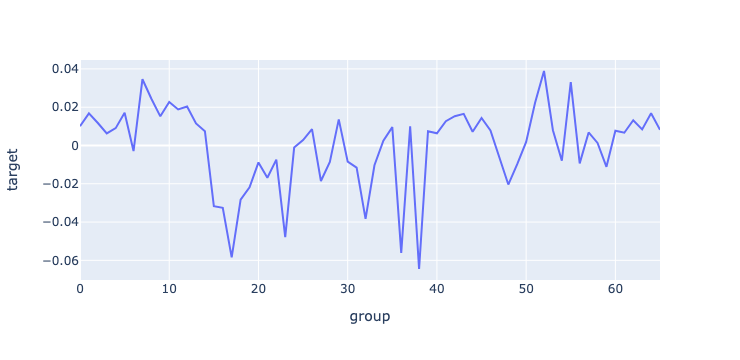

In [23]:
train_data["group"] = train_data["id"].apply(lambda x: x//10000)
train_data_for_plot = train_data[['group', 'target']].groupby('group').mean().reset_index()
px.line(train_data_for_plot, x='group', y='target')

## モデルの学習

In [10]:
# サンプリング（時間短縮のため）
sample_train_data = train_data.sample(frac=0.1)

In [11]:
# データ分割
# TODO: 時系列データであることを考慮すべき？
feature_cols = sample_train_data.drop(columns=["id", "target"]).columns
target_col = "target"
X_train, X_valid, y_train, y_valid = train_test_split(
    sample_train_data[feature_cols], 
    sample_train_data[target_col], 
    test_size=0.3
)
print(f'X_trainのshape:{X_train.shape}')
print(f'y_trainのshape:{y_train.shape}')
print(f'X_validのshape:{X_valid.shape}')
print(f'y_validのshape:{y_valid.shape}')

X_trainのshape:(46200, 695)
y_trainのshape:(46200,)
X_validのshape:(19800, 695)
y_validのshape:(19800,)


In [12]:
# パラメータの準備
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'None',
    'num_leaves':16,
    'learning_rate':0.1,
    'n_estimators':100000,
    'random_state':0
}

In [13]:
# インスタンスの作成
clf = lgb.LGBMRegressor(**params)

In [14]:
# モデルの学習
clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train),(X_valid, y_valid)],
    eval_metric=cosine_similarity,
    early_stopping_rounds=100
)

/Users/ryusuke/anaconda3/envs/work/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's cosine_similarity: 0.092897	valid_1's cosine_similarity: 0.0105684
[2]	training's cosine_similarity: 0.129123	valid_1's cosine_similarity: 0.0285453
[3]	training's cosine_similarity: 0.149792	valid_1's cosine_similarity: 0.0301964
[4]	training's cosine_similarity: 0.163126	valid_1's cosine_similarity: 0.0336029
[5]	training's cosine_similarity: 0.177945	valid_1's cosine_similarity: 0.0403389
[6]	training's cosine_similarity: 0.188803	valid_1's cosine_similarity: 0.0464962
[7]	training's cosine_similarity: 0.200206	valid_1's cosine_similarity: 0.0479904
[8]	training's cosine_similarity: 0.207519	valid_1's cosine_similarity: 0.0495138
[9]	training's cosine_similarity: 0.216877	valid_1's cosine_similarity: 0.0487798
[10]	training's cosine_similarity: 0.224312	valid_1's cosine_similarity: 0.0487913
[11]	training's cosine_similarity: 0.232915	valid_1's cosine_similarity: 0.0505653
[12]	training's cosine_similarity: 0.236321	valid_1's cosine_similarity: 0.0490197
[13]	training

LGBMRegressor(metric='None', n_estimators=100000, num_leaves=16,
              objective='regression', random_state=0)

In [15]:
# 精度
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print(f"trainの精度：{cosine_similarity(y_train, y_train_pred)[1]}")
print(f"validの精度：{cosine_similarity(y_valid, y_valid_pred)[1]}")

trainの精度：0.9388890105696042
validの精度：0.1523830198362093


## テストデータの予測

In [69]:
# 予測
id_test = test_data["id"].values.reshape(-1)
X_test = test_data.drop(columns=["id"]).copy()
y_test_pred = clf.predict(X_test)

In [73]:
pd.DataFrame(y_test_pred)

,0
0,0.435758
1,0.224413
2,0.278932
3,-0.186025
4,-0.476796
...,...
261656,-0.073001
261657,0.048334
261658,-0.004675
261659,0.023047


In [89]:
# 保存
result = pd.DataFrame(data=y_test_pred, index=id_test, columns=["target"]).reset_index().rename(columns={"index": "id"})
result.to_csv(Path(RESULT_PATH, "20230816_result.csv"), index=False)